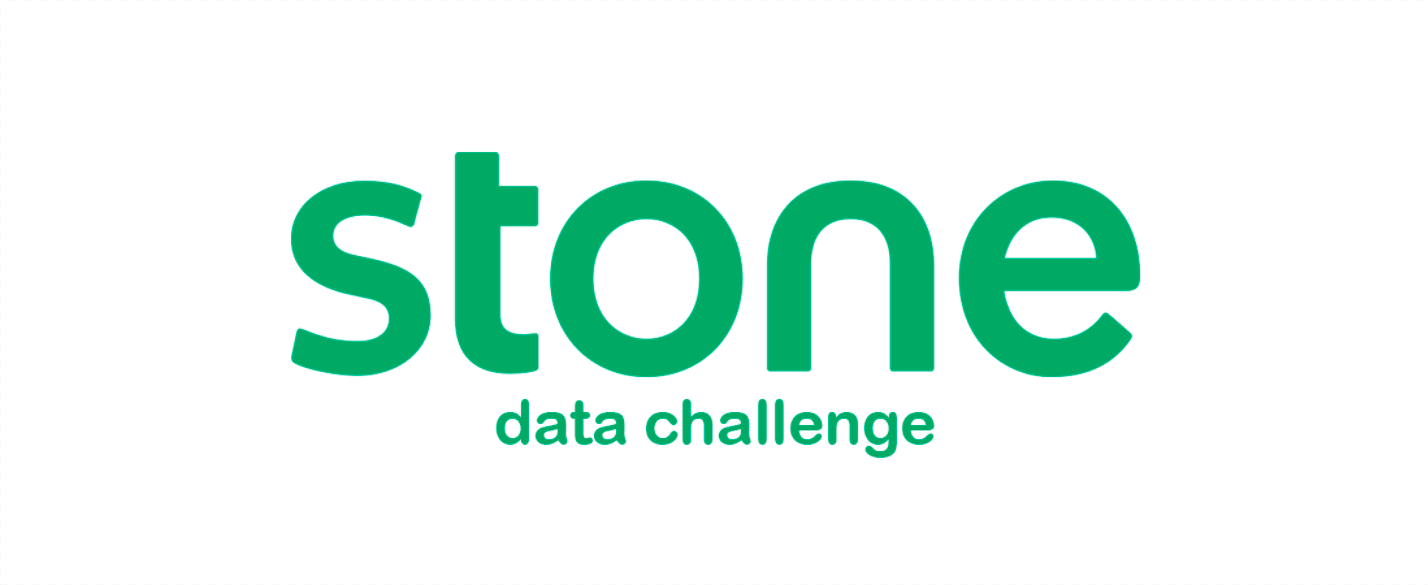

Nesse notebook, foi realizado o EDA - Exploratory Data Analysis. Além de realizar alguns procedimentos padrões para a criação do modelo (distribuições, correlação e etc), procurei entender um pouco mais sobre o dataset, realizando a exploração guiado por perguntas que eu criei enquanto limpava-o.

### **Informações Encontradas e Conclusões**:

* **Novos clientes**
	* O número de contas criadas na Stone vem crescendo de forma expressiva desde o ano de 2016.
	* Aparentemente, esse crescimento encontrou um platô e vem caindo, durante o início 2020.
    
    
* **Tempo para realização da primeira transação após a abertura da conta**
	* Aproximadamente 35% dos clientes demoram em até um dia após a criação da conta Stone para realizar a primeira transação. 85% dos clientes começam a vender com a Stone em até 10 dias.
	* Com exceção do cliente que é uma Cia Aérea e clientes com categoria "Missing Value", visualizar esse tempo por segmentos gera resultados bem similares aos de cima.
	* Em algumas observações, a diferença entre a data da primeira transação e a de criação da conta é negativa.
    
    
* **MacroClassificação e Segmentos**
	* A alimentação é o setor que a Stone tem o maior número de parceiros, seguido de Bens Duráveis, Varejo e Serviços.
	* Viagens e Entretenimento e Postos de Combustíveis são os setores que tem menor número de IDs.
		* No entanto, Postos possuem a maior mediana entre os TPV-mensais médios de todos os setores conhecidos no dataset (tanto comparando segmentos quanto as macroclassificações)
	* Em escala log, a distribuição do TPV-mensal médio entre os diferentes segmentos se aproxima de uma curva normal. 
	* A distribuição do TPV-mensal médio de muitas macroclassificações e segmentos é bem parecida! Tanto no formato (assimétrica à esq.) quanto nos valores das estatísticas de localização.
		* As exceções positivas são os Materias de Construção, Supermercados, Logística e Mobilidade e Educação dentro dos segmenttos.
		* Já serviços gerais, como serviços de estética e consertos possuem tpv-mensal médio menor. 
        
        
* **Porte**
	* O porte mais comum no dataset (e isso se repete em todos as MacroClassificações) é entre 10k e 25k.
	* Ignorando o fato do porte ser dado de forma binnada por um instante, a distribuição do porte se aproxima muito de uma curva normal também.
	* Como era esperado, o porte influencia MUITO no TPV-mensal médio e de forma bem linear: maior o porte, maior a mediana do TPV-mensal e mais espaçada a distribuição dele entre as empresas. 
    
    
* **Tipo de Documento**
	* MEI e PJs separados.
	* Maioria dos parceiros da Stone são PJ (~70%) e, no Brasil, o tipo de empresa mais comum é o MEI.
	* Como esperado devido às restrições de receita de MEI e de PF, o TPV-Mensal dos clientes PJ posssui mediana maior que o terceiro quartil dos outros dois. Apesar disso, a distribuição do TPV nos 3 tipos é similar.
	* O número de contas MEI e PF vem crescendo em um ritmo maior que os PJs desde a metade de 2017.
    
    
* **Estado**
	* Devido à população absoluta de SP, ele é o estado com maior valor absoluto de parceiros Stone.
	* Considerando o número de contas p/ milhão de hab., estados do Sul como SC e PR são líderes de parceiros, junto com o DF. Pelo contrário, a menor participação p/ milhão de hab. está nos estados do Nordeste e Norte.
	* Em relação ao desempenho do TPV-mensal por UF, alguns destaques positivos são o DF, MS, PE e o TO, com a mediana acima dos outros estados. Já o ES e a maior parte dos estados do Norte possuem a mediana abaixo.
    
    
* **Persona**
	* Empresas de pequeno e médio porte estão em maioria entre as parceiras da Stone. 
	* Persona "Digital - Micro" tem apenas duas empresas.
	* Já na distribuição da média do TPV-Mensal, dá pra perceber que a diferença existe no tamanho do porte e não no tamanho do ticket. 
    
    
* **TPV-mensais**
	* Devido ao volume de dados, as análises das distribuições do TPV-mensal citadas acima utilizavam a média do TPV por empresa.
	* Em escala log, a distribuição de todos os valores TPV-Mensal se aproxima da curva normal.
	* O TPV cumulativo mostra que as diferentes macroclassificações estão com o TPV crescendo de maneira parecida, mas Supermercados e Farmácias tem destaque no ritmo do crescimento.
    
    
* **Análise de Componentes Temporais**
	* **Tendência**

    	*  Viagens e Entretenimento começou 2018 subindo mas voltou a cair após atingir um platô em 2019. A mediana do TPV-Mensal super mercados e farmácias está subindo. Já o resto das macroclassificações possui a mediana do TPV-mensal em queda.

    	* Vale lembrar que houve um aumento exponencial no número de MEIs e PFs a partir do meio de 2017, o que pode explicar a tendência de queda da mediana do TPV-Mensal em muitas macroclassificações, uma vez que empresas menores estão entrando.
	* **Sazonalidade**
    	* Os meses de Novembro e Dezembro são favoráveis pra grande maioria das empresas.
    	* Apesar de algumas similaridades, dá pra notar também que o comportamento da sazonalidade, mesmo considerando apenas a mediana, é diferente entre as classificações.

## Iniciando o Notebook

In [1]:
# Warning - Future
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import libs - wrangling e analysis
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Plots
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Processing
from sklearn.preprocessing import MinMaxScaler

# Helper
from helper import dict_estados

In [2]:
# Import nos datasets
cadastrais = pd.read_csv('data/cadastrais-limpo.csv', parse_dates = ['StoneCreatedDate', 'StoneFirstTransactionDate'])
cadastrais.drop("Unnamed: 0", axis = 1, inplace = True)

tpv_mensais = pd.read_csv('data/tpv-mensais-limpo.csv', parse_dates = ['mes_referencia'])
tpv_mensais.drop("Unnamed: 0", axis = 1, inplace = True)

estimativa_tpv_medio_ci = pd.read_csv('data/estimativa-e-tpv-medio-ci.csv')
estimativa_tpv_medio_ci.drop("Unnamed: 0", axis = 1, inplace = True)

# Styling dos plots e dos DataFrames
sns.set_style('white')
sns.set_context('talk')
plt.rc("axes.spines", top=False, right=False)

pd.options.display.float_format = '{:,.2f}'.format
pal = sns.color_palette('colorblind')
g = sns.color_palette('viridis_r', 30)[9]

## Cadastrais

Brainstorm de perguntas sobre o Dataset

* Temporais - StoneCreatedDate e StoneFirstTransactionDate
    * Dados temporais em relação a criação das contas
        * Qual a tendência do crescimento em relação ao número de contas?
        * Houve alguma época específica que ocorreu um aumento expressivo no número de contas?
    * Quanto tempo leva da criação da conta a primeira venda?
* Dá pra descobrir o que com o MCC?
* Quais são os segmentos mais comuns? E os sub-segmentos?
* Relação entre o segmento e o porte
* Relação entre o segmento e o tipo_documento
* Quais Estados a Stone tem maior número de parceiros? Esse número continua o mesmo se relativizarmos a população?
* Qual é o porte mais comum entre as empresas? 

### Descritivos

In [3]:
cadastrais.head()

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate
0,1,"5,942.00",Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,"71,000.00",PJ,MG,0,2018-12-12,2018-12-13
1,2,"5,231.00",Bens duráveis,Materiais de Construção,Materiais de Construção,SMB - Pequeno Porte e Ticket Alto,10k-25k,"10,001.00",PF,RS,0,2020-04-13,2020-04-14
2,3,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,Pequeno Empreendedor,2.5k-5k,"3,000.00",PF,RJ,0,2019-05-31,2019-06-15
3,4,"4,215.00",Serviços,Logística e Mobilidade,Delivery e Entrega,SMB - Medio Porte e Ticket Medio,25k-50k,"25,000.00",PJ,RJ,0,2017-09-29,2017-10-02
4,5,"5,698.00",Serviços,Serviços de Beleza e Estética,Salão de Beleza,SMB - Pequeno Porte e Ticket Medio,5k-10k,"6,000.00",PF,PE,0,2019-01-31,2019-01-31


In [4]:
print(f"CADASTRAIS:\nNúmero de observações:{cadastrais.shape[0]}\nNúmero de Variáveis:{cadastrais.shape[1]}")
print("\n==================================\nINFO")
print(f"{cadastrais.info()}")
print("\n===============\nNaNs:")
cadastrais.isnull().sum()

CADASTRAIS:
Número de observações:205833
Número de Variáveis:13

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205833 entries, 0 to 205832
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         205833 non-null  int64         
 1   MCC                        205833 non-null  float64       
 2   MacroClassificacao         205833 non-null  object        
 3   segmento                   205833 non-null  object        
 4   sub_segmento               205833 non-null  object        
 5   persona                    205833 non-null  object        
 6   porte                      205833 non-null  object        
 7   TPVEstimate                205833 non-null  float64       
 8   tipo_documento             205833 non-null  object        
 9   Estado                     205833 non-null  object        
 10  tem_duplicados             205833 non-null  in

id                           0
MCC                          0
MacroClassificacao           0
segmento                     0
sub_segmento                 0
persona                      0
porte                        0
TPVEstimate                  0
tipo_documento               0
Estado                       0
tem_duplicados               0
StoneCreatedDate             0
StoneFirstTransactionDate    0
dtype: int64

Como a limpeza dos dados já foi realizada, tudo está como esperado - dtypes e shape corretos, NaNs fillados. A única mudança que irei realizar é a transformação do MCC para dado categórico.

In [5]:
cadastrais.describe(include = ['float', 'int'])

,MCC,TPVEstimate
count,"205,833.00","205,833.00"
mean,"5,919.44","95,883.96"
std,"1,069.04","28,662,939.67"
min,0.00,0.00
25%,"5,462.00","10,000.00"
50%,"5,722.00","12,500.00"
75%,"5,977.00","25,000.00"
max,"9,950.00","12,996,174,943.00"


In [6]:
cadastrais[cadastrais['MacroClassificacao'].isnull()]

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate


Como essas rows possuem pouquíssimos dados que não são NaN, eu droparia elas caso não precisasse entregar todas IDs em um DataFrame com os resultados. No entanto, para uso de alguns modelos lineares, irei dar fillna com uma string. 

In [7]:
cadastrais['MCC'] = cadastrais['MCC'].astype('int').astype('category')
cadastrais['id'] = cadastrais['id'].astype('category')
cadastrais['tem_duplicados'] = cadastrais['tem_duplicados'].astype('category')

cadastrais.describe(include = ['object', 'category',  'datetime'])

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate
count,"205,833.00","205,833.00",205833,205833,205833,205833,205833,205833,205833,"205,833.00",205833,205833
unique,"205,833.00",259.00,9,30,82,13,8,3,28,2.00,2278,2562
top,1.00,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Medio,10k-25k,PJ,SP,0.00,2019-12-13 00:00:00,2020-01-31 00:00:00
freq,1.00,"15,714.00",57097,57097,26922,42708,75871,145386,54267,"164,773.00",924,1003
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-02-24 00:00:00,2013-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-15 00:00:00,2020-05-31 00:00:00


### Dados Temporais

Inicialmente, vamos observar os dados relacionados à criação de novas contas Stone. Para isso, irei desconsiderar as contas "criadas" em 1990, uma vez que são erros de inserção de dados e são a minoria.

* O número de contas Stone criadas está crescendo em que velocidade?
* Qual a tendência do crescimento do número de contas criadas?
* Qual é o tempo que demora para realizar a primeira transação a partir da data da criação da conta?
    * Ele muda entre os diferentes segmentos?

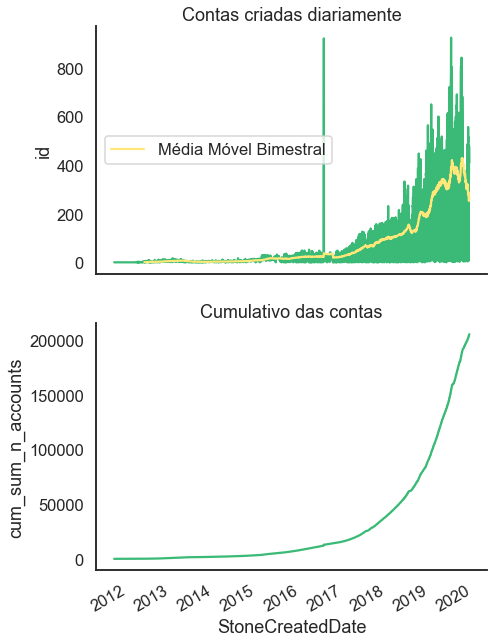

In [8]:
# Agrupar pela data de criação e contar o número de contas criadas por data
groupby_date = cadastrais.groupby('StoneCreatedDate').count().sort_index()

groupby_date['cum_sum_n_accounts'] = groupby_date['id'].cumsum()

fig, axs = plt.subplots(2, figsize = (7,10), sharex = True)


sns.lineplot(x = groupby_date.index, y = 'id',
             data = groupby_date, color = g, ax = axs[0], alpha = 1).set_title("Contas criadas diariamente")

sns.lineplot(x = groupby_date.index, y = groupby_date['id'].rolling(60).mean(),
             color = '#FFE77AFF', ax = axs[0], label = 'Média Móvel Bimestral')

sns.lineplot(x = groupby_date.index, y = 'cum_sum_n_accounts',
             data = groupby_date, color = g, ax = axs[1], alpha = 1).set_title("Cumulativo das contas")

plt.xticks(rotation = 30);

É possível observar um **crescimento exponencial a partir do ano de 2016**, ano em que a Stone **adquiriu a Elavon**. Além disso, no início de 2017 é possível observar um outlier bem expressivo no número de contas criadas. Não consegui encontrar nenhum motivo para isso - como uma promoção ou propaganda de final de 2016/ínicio de 2017 - e a minha hipótese é que seja a entrada de contas que não foram feitas no final do ano, tudo de uma vez só.
<br>

**A partir do meio de 2019 houve uma queda no crescimento do número de contas**, formando quase o início de uma função logarítmica. Essa queda, em conjunto com a pandemia, pode ser uma das explicações da desaceleração dos resultados da Stone no ano de 2020.

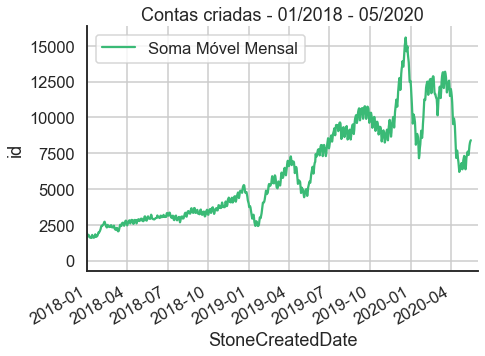

In [9]:
fig, ax = plt.subplots(figsize = (7,5))


sns.lineplot(x = groupby_date.index, y = groupby_date['id'].rolling(30).sum(),
             color = g, ax = ax, label = 'Soma Móvel Mensal').set_title("Contas criadas - 01/2018 - 05/2020")

datemin = np.datetime64('2018-01-01')
datemax = np.datetime64('2020-05-31')
ax.set(xlim = (datemin, datemax))

plt.grid()
fig.autofmt_xdate()

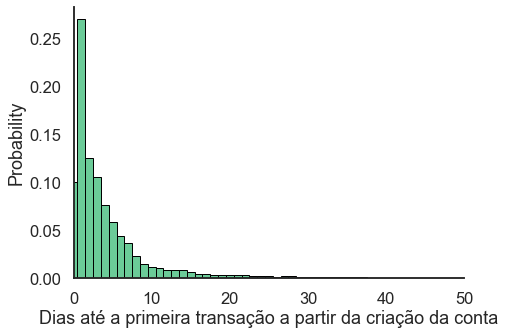

In [10]:
# Tempo para realizar a primeira transação após a criação da conta
cadastrais['diff_FirstTransaction_Created'] = (cadastrais['StoneFirstTransactionDate'] - cadastrais['StoneCreatedDate']).dt.days

order = cadastrais['diff_FirstTransaction_Created'].value_counts()[:50].index

# Histograma tradicional

fig, ax = plt.subplots(figsize = (7,5))

sns.histplot(x = cadastrais['diff_FirstTransaction_Created'], stat="probability",
            discrete = True, bins = 20, ax = ax, edgecolor='k', linewidth=1, color = g)

ax.set(xlim = (0,50),
       xlabel = 'Dias até a primeira transação a partir da criação da conta');

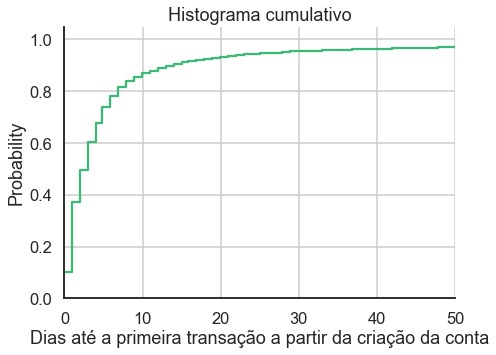

In [11]:
# Histograma cumulativo
fig, ax = plt.subplots(figsize = (7,5))

sns.histplot(x = cadastrais['diff_FirstTransaction_Created'], stat="probability",
             ax = ax, element="step", fill = False, cumulative = True, color = g)

ax.set(xlim = (0,50),
       xlabel = 'Dias até a primeira transação a partir da criação da conta',
       title = 'Histograma cumulativo');

plt.grid()

In [12]:
display(cadastrais[cadastrais['diff_FirstTransaction_Created'] < 0].head())

print(f"Número de Rows com diff_FirstTransaction_Created < 0: {len(cadastrais[cadastrais['diff_FirstTransaction_Created'] < 0])}")

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate,diff_FirstTransaction_Created
700,702,7372,Bens duráveis,Eletroeletrônicos,Softwares e Eletrônica Integrada,Outro,0-2.5k,0.00,PJ,SP,1,2015-01-06,2014-02-07,-333
1979,1983,7538,Serviços,Autopeças e Serviços Automotivos,Oficinas Automotivas,SMB - Pequeno Porte e Ticket Medio,5k-10k,"10,000.00",PJ,SP,0,2020-02-01,2020-01-31,-1
3932,3936,7296,Varejo,Moda e Acessórios,Vestuário,Outro,100k-500k,0.00,PJ,RJ,1,2014-03-15,2014-02-10,-33
4223,4227,4816,Bens duráveis,Telecomunicações,Telecomunicações,Outro,5k-10k,0.00,PJ,RJ,1,2015-03-09,2014-11-19,-110
8307,8312,5122,Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,Outro,2.5k-5k,0.00,PJ,MG,1,2015-01-06,2014-09-16,-112


Número de Rows com diff_FirstTransaction_Created < 0: 59


A maioria dos parceiros da Stone demora poucos dias para começar a realizar vendas com a máquininha:
* Aproximadamente 35% dos clientes demoram entre 0 a 1 dia após a criação da conta Stone
* Aproximadamente 85% dos clientes começam a vender com a Stone em até 10 dias da criação da conta.
<br>

Em algumas observações, **a diferença entre a data da primeira transação e a de criação da conta é negativa** - o que eu já havia percebido nos dados originais.

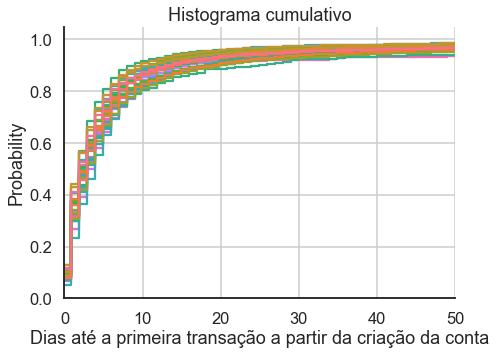

In [13]:
fig, ax = plt.subplots(figsize = (7,5))

segmentos_outliers = ['Missing Value', 'Cias Aéreas']

sns.histplot(x = 'diff_FirstTransaction_Created', stat= 'probability', ax = ax,
             data = cadastrais[~cadastrais['segmento'].isin(segmentos_outliers)],
             hue = 'segmento', element= 'step', fill = False,
             cumulative = True, common_norm = False)

ax.set(xlim = (0,50),
       xlabel = 'Dias até a primeira transação a partir da criação da conta',
       title = 'Histograma cumulativo')

ax.get_legend().remove()
plt.grid()

Apesar da poluição devido ao número de segmentos, é possível ver que quase todos os segmentos se comportam da mesma forma em relação ao número de dias até a primeira transação. Os únicos segmentos que não se encaixam são a Cia Aérea (pois tem apenas uma entrada) e o Missing Values, definido anteriormente através dos valores NaNs.

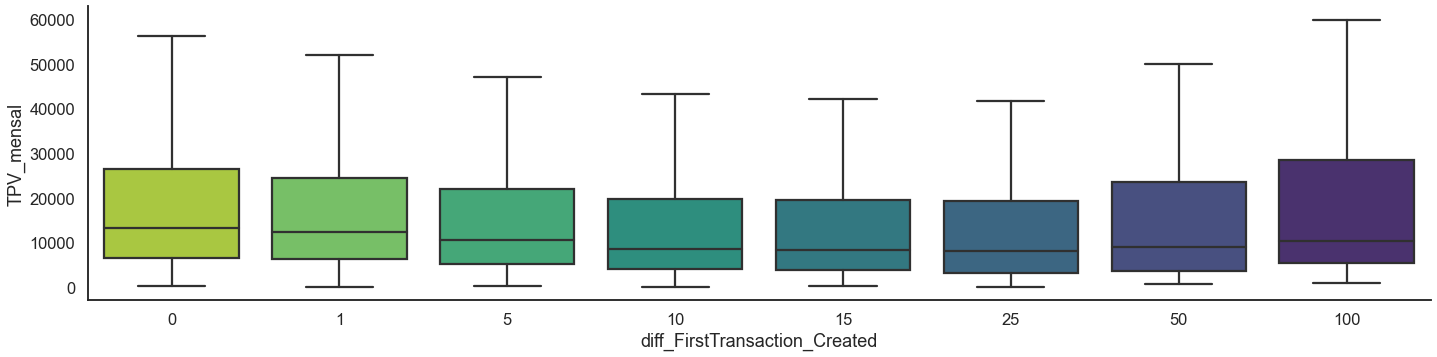

In [14]:
# Merge do cadastrais com o DataFrame estimativa_tpv_medio_ci criado anteriormente

cad_est_tpv_medio_ci = cadastrais.merge(estimativa_tpv_medio_ci,
                                        on = 'id', suffixes=(None, '_y')).drop('TPVEstimate_y', axis = 1)

# BoxPlot do TPV-Mensal de alguns dos vvalores

order = np.array([0,1,5,10,15,25,50,100])

sns.catplot(x = 'diff_FirstTransaction_Created', y = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci, order = order,
            aspect = 4, showfliers=False, palette = 'viridis_r');


O tempo para realizar a primeira transação não parece afetar muito a distribuição do TPV-mensal.

### MCC

O MCC é descrito no PDF do case como a codificação do segmento do cliente em uma visão menos agrupada. Por estar em código, não é possível definir exatamente o que cada um deles significa sem o uso de um dicionário dos códigos.

In [15]:
cadastrais['MCC'].value_counts()

5499    15714
5814    14916
5411    14490
5651    13324
5812    10935
        ...  
6051        1
4821        1
7993        1
7996        1
9950        1
Name: MCC, Length: 259, dtype: int64

In [16]:
cadastrais[(cadastrais['MCC'] == 5499)].head()

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate,diff_FirstTransaction_Created
5,6,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Medio Porte e Ticket Baixo,50k-100k,"37,000.00",PJ,SC,0,2019-09-24,2019-09-25,1
24,25,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Medio Porte e Ticket Baixo,25k-50k,"30,000.00",PJ,SP,0,2020-01-16,2020-01-17,1
46,47,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,5k-10k,500.00,PF,ES,0,2019-12-05,2019-12-08,3
49,50,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"18,500.00",PJ,SP,0,2017-11-07,2017-11-10,3
50,51,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Medio Porte e Ticket Baixo,50k-100k,"56,000.00",PF,RJ,0,2018-09-19,2018-09-21,2


In [17]:
cadastrais[cadastrais['MacroClassificacao'] == 'Alimentação'].head()

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate,diff_FirstTransaction_Created
5,6,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Medio Porte e Ticket Baixo,50k-100k,"37,000.00",PJ,SC,0,2019-09-24,2019-09-25,1
9,10,5422,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Grande Porte e Ticket Baixo,100k-500k,"114,400.00",PJ,SC,0,2017-11-14,2017-11-14,0
17,18,5814,Alimentação,Alimentação e Bebidas,Alimentação Rápida,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"15,000.00",PJ,RS,0,2018-12-20,2018-12-21,1
19,20,5812,Alimentação,Alimentação e Bebidas,Bares e Restaurantes,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"20,000.00",PJ,SC,0,2019-07-26,2019-08-01,6
24,25,5499,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Medio Porte e Ticket Baixo,25k-50k,"30,000.00",PJ,SP,0,2020-01-16,2020-01-17,1


Deu pra concluir que não é possível tirar muita informação do MCC, uma vez que são muitas categorias diferentes (259) e algumas observações com MCC diferentes possuem outras váriveis categóricas iguais. 

Com mais tempo, dava pra realizar uma análise mais profunda - no entanto, o desafio tem prazo.  

### Classificação e Segmentos
* Quais são os segmentos mais comuns? E os sub-segmentos?
* Relação entre o segmento e o porte
* Relação entre o segmento e o tipo_documento
* Quais Estados a Stone tem maior número de parceiros? Esse ordenamento continua o mesmo se relativizarmos a população?
* Qual é o porte mais comum entre as empresas? 

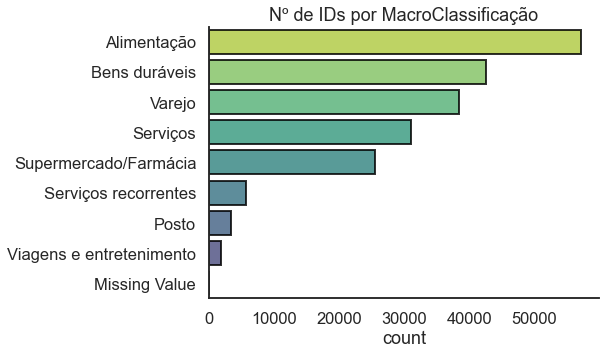

In [18]:
fig, ax = plt.subplots(figsize = (7,5))

order = np.array(cadastrais['MacroClassificacao'].value_counts().index)

cp_kwargs = dict(data = cadastrais,
                 orient = 'v', palette = 'viridis_r',
                 alpha = 0.8, linewidth=2,
                 edgecolor = 'k')

sns.countplot(y = 'MacroClassificacao', order = order, **cp_kwargs)

ax.set(title = "Nº de IDs por MacroClassificação",
       ylabel = '');

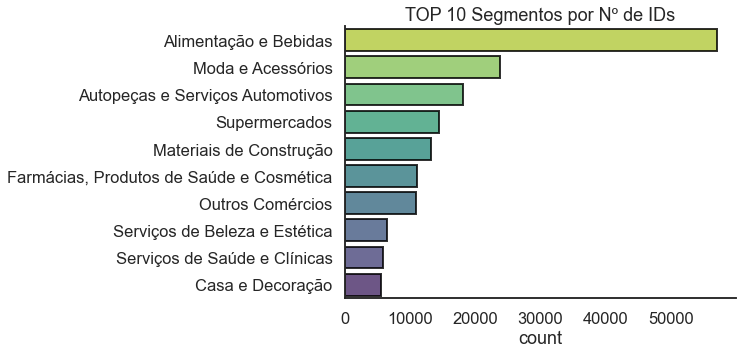

In [19]:
fig, ax = plt.subplots(figsize = (7,5))

order = np.array(cadastrais['segmento'].value_counts().index)[:10]

sns.countplot(y = 'segmento', order = order, **cp_kwargs)

ax.set(title = "TOP 10 Segmentos por Nº de IDs",
       ylabel = '');

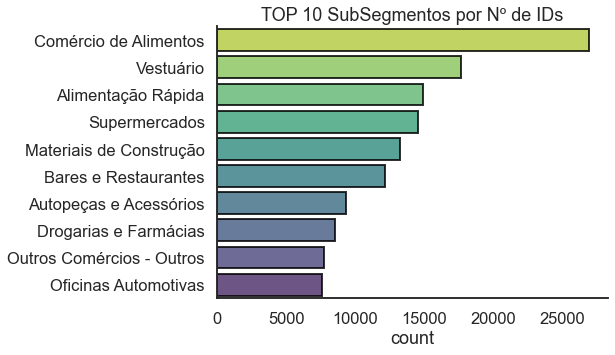

In [20]:
fig, ax = plt.subplots(figsize = (7,5))

order = np.array(cadastrais['sub_segmento'].value_counts().index)[:10]

sns.countplot(y = 'sub_segmento', order = order, **cp_kwargs)

ax.set(title = "TOP 10 SubSegmentos por Nº de IDs",
       ylabel = '');

A **MacroClassificação mais comum no dataset é a de Alimentação** e como ela tem apenas um segmento (Alimentação e Bebidas), ele acaba sendo o segmento mais comum também - de forma bem expressiva. A Stone também marca grande presença nos setores de Bens Duráveis, Varejo, Serviços e Supercado/Farmácia, ao contrário do seu espaço em Postos e nos setores de Viagens e Entretenimento.   

In [21]:
cad_est_tpv_medio_ci.groupby('MacroClassificacao').median()

,id,TPVEstimate,diff_FirstTransaction_Created,TPV_mensal,diff,TPV_medio_CI_LOW,TPV_medio_CI_HIGH,is_estimate_in_CI
MacroClassificacao,,,,,,,,
Alimentação,"105,916.00","15,000.00",2.00,"11,217.89","3,531.44","7,297.18","14,905.15",0.00
Bens duráveis,"105,728.50","15,000.00",3.00,"13,321.79","2,452.85","8,510.92","17,712.10",0.00
Missing Value,"119,242.00",0.00,21.00,"26,574.64","-24,147.15","13,790.13","34,713.19",0.00
Posto,"103,764.00","26,000.00",3.00,"23,132.72","3,746.28","16,148.95","29,240.35",0.00
Serviços,"94,700.00","10,500.00",3.00,"8,605.69","3,066.77","5,325.71","11,731.08",0.00
Serviços recorrentes,"95,394.00","12,173.00",4.00,"11,693.95","2,558.35","7,232.14","15,950.63",0.00
Supermercado/Farmácia,"105,050.00","15,000.00",3.00,"13,187.22","1,242.26","8,741.77","17,252.10",0.00
Varejo,"102,727.00","10,000.00",3.00,"10,188.43","2,743.76","5,967.24","14,040.76",0.00
Viagens e entretenimento,"109,234.00","12,000.00",3.00,"10,426.09","3,664.84","6,419.44","14,379.70",0.00


Ao contrário de quando observamos os IDs de forma singular, **a mediana do TPVEstimate se aproxima muito da mediana do TPV_mensal médio dos IDs agrupados por MacroClassificação** - o que é muito interessante e me faz ter mais curiosidade de entender como ele é calculado.
<br>

Vamos observar a distribuição do TPV mensal por MacroClassificação:

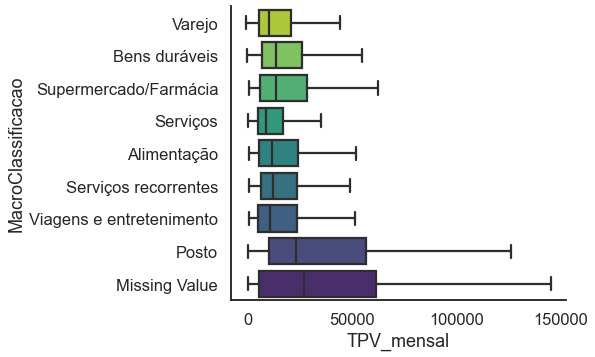

In [22]:
sns.catplot(y = 'MacroClassificacao', x = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 1.6, showfliers=False, palette = 'viridis_r');

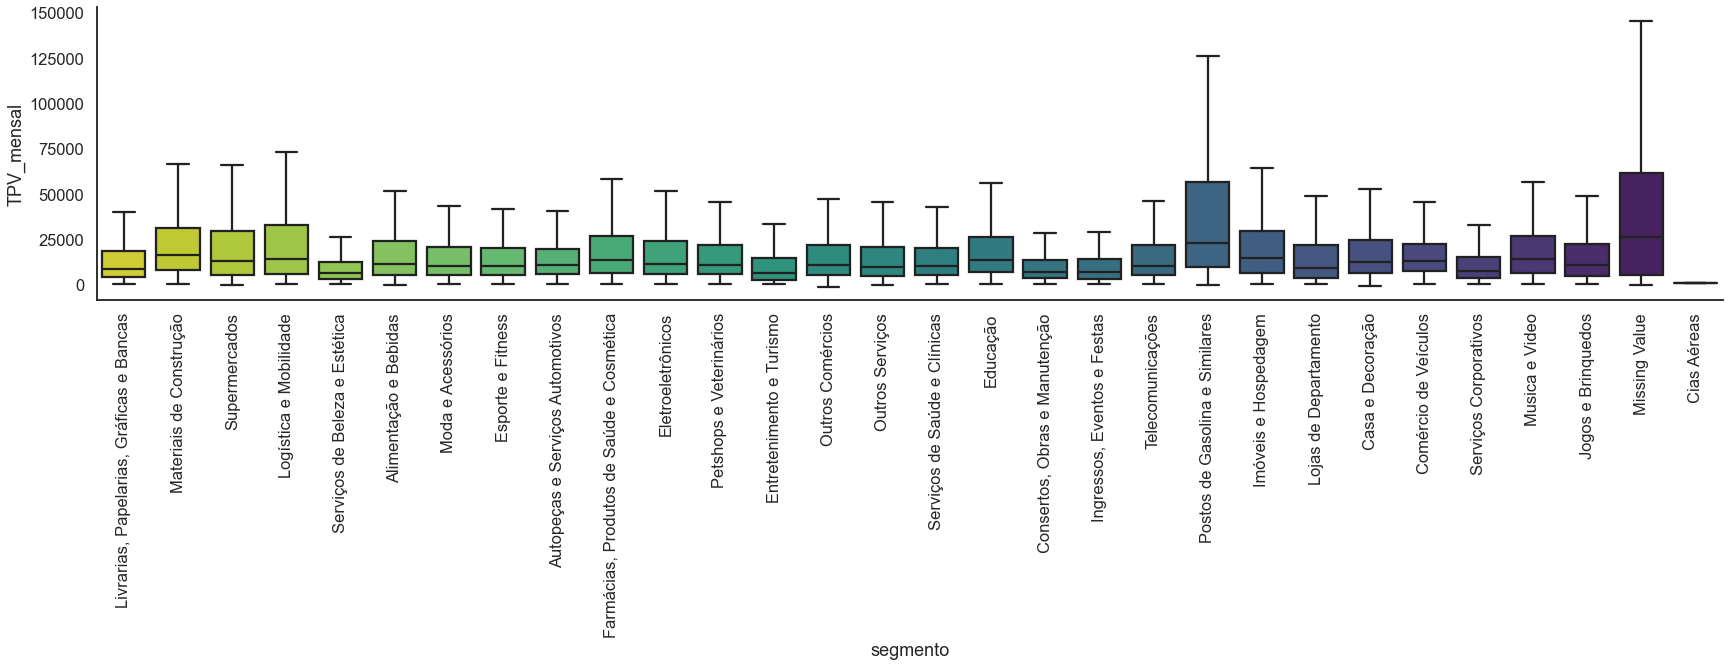

In [23]:
sns.catplot(x = 'segmento', y = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 5, showfliers=False, palette = 'viridis_r');

plt.xticks(rotation = 90);

A distribuição do TPV Mensal das MacroClassificações Bens Duráveis, Alimentação, Serviços Recorrentes e Viagens e Entretenimento é bem parecida! 
<br>

Válido apontar para a distribuição do TPV Mensal dos **Postos, que possui a maior mediana entre os as MacroClassificações** (desconsiderando os NaNs). Poderia ser interessante para a Stone entrar no mercado de Postos de Gasolina - no entanto, imagino que as taxas para esse tipo de estabelecimento sejam extremamente baixas.
<br>

Outra coisa interessante de perceber é a **distribuição de todas as MacroClassificações ser assimétrica à esquerda**, o que é comum para comércios, distribuições de renda e outros.
<br>

O mesmo comportamento ocorre com o boxplot da distribuição do TPV-mensal por segmentos. Missing Values e Postos de Gasolina com um comportamento bem separado do resto. No entanto, podemos ver 

C:\Users\bueni\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


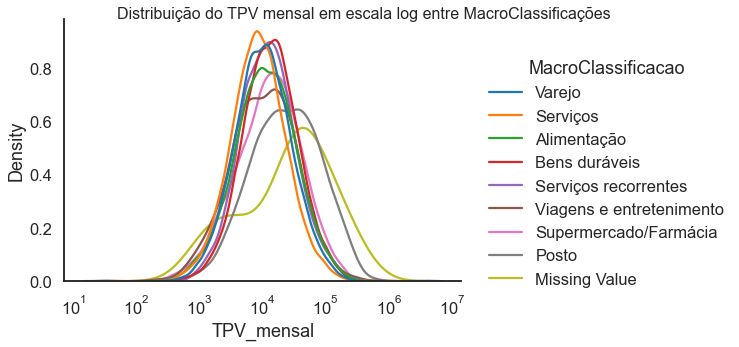

In [24]:
np.random.seed(42)

fig = sns.displot(x = 'TPV_mensal', hue = 'MacroClassificacao',
                  kind = 'kde', data = cad_est_tpv_medio_ci.sample(100000),
                  aspect = 1.4, log_scale = True, common_norm = False);

fig.fig.suptitle('Distribuição do TPV mensal em escala log entre MacroClassificações',
                 fontsize = 16);

O gráfico KDE mostra a distribuição em um estilo diferente, mas percebemos que o comportamento do Posto e do Missing Value continua diferente do resto das classificações.

Vamos explorar um pouco mais sobre o porte das empresas como um todo e como ele se comporta por MacroClassificação. 

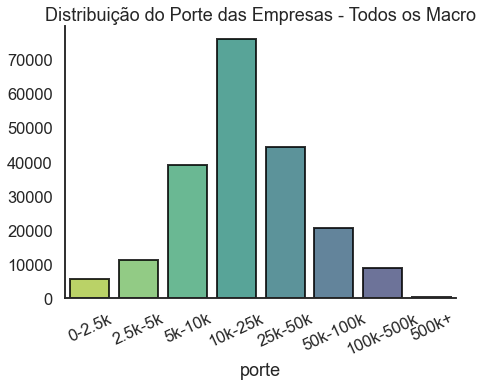

In [25]:
fig, ax = plt.subplots(figsize = (7,5))

order = ['0-2.5k', '2.5k-5k','5k-10k', '10k-25k', '25k-50k', '50k-100k', '100k-500k', '500k+']

sns.countplot(x = 'porte', order = order, **cp_kwargs)

ax.set(title = "Distribuição do Porte das Empresas - Todos os Macro",
       ylabel = '');

plt.xticks(rotation = 25);

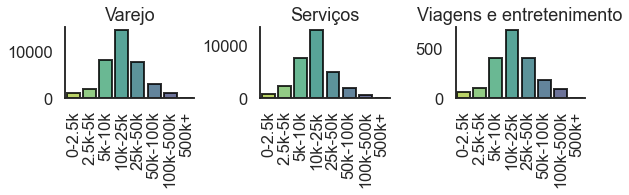

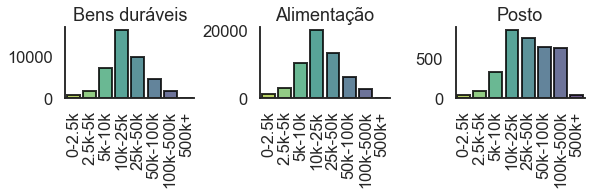

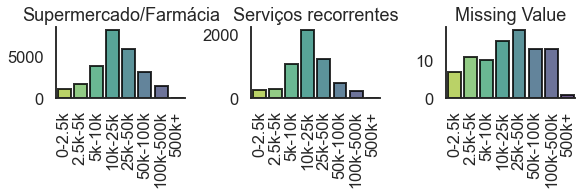

In [26]:
cp_kwargs.pop('data')

for ramo_1, ramo_2, ramo_3 in zip(cad_est_tpv_medio_ci['MacroClassificacao'].unique()[:3],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[3:6],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[6:9]):
    
    fig, axs = plt.subplots(1, 3, figsize = (8.4,2))
    plt.tight_layout()
    for ramo, ax in zip([ramo_1, ramo_2, ramo_3], [axs[0], axs[1], axs[2]]):
         
        data = cad_est_tpv_medio_ci[cad_est_tpv_medio_ci['MacroClassificacao'] == ramo]
        
        sns.countplot(x = 'porte', data = data, order = order, ax = ax, **cp_kwargs)
        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

        ax.set(title = f"{ramo}",
               ylabel = '',
               xlabel = '');

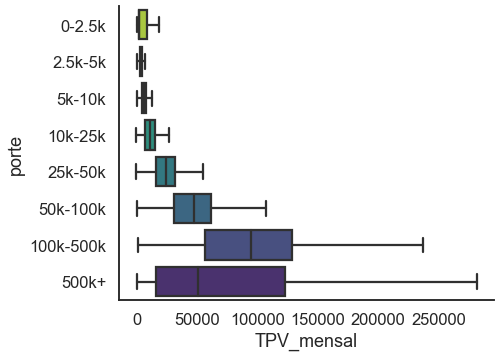

In [27]:
sns.catplot(y = 'porte', x = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 1.4, order = order, showfliers=False, palette = 'viridis_r');

Assim como na distribuição do TPV-Mensal, as **categorias que se destacam pela diferença quando comparadas ao resto são a Missing Value e o Posto** - a primeira possívelmente pelo número de dados e o segundo pela combinação do número de dados e o tipo de estabelecimento.
<br>

Além disso, podemos ver que a distribuição da média do TPV-Mensal muda de forma bem expressiva quando comparamos os diferentes portes. Isso é esperado, claro, mas a confimação é interessante para a engenharia de features

### Tipo de Documento

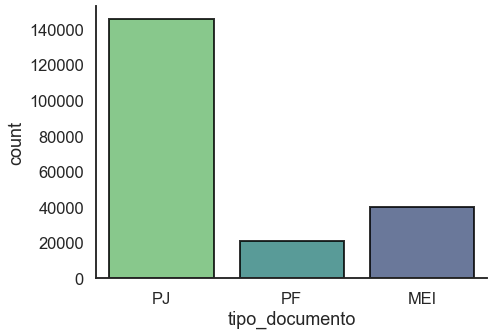

In [28]:
fig, ax = plt.subplots(figsize = (7,5))

sns.countplot(x = 'tipo_documento', data = cad_est_tpv_medio_ci,
              ax = ax, **cp_kwargs);

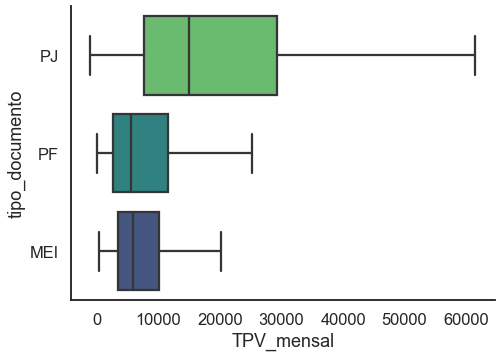

In [29]:
sns.catplot(y = 'tipo_documento', x = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 1.4, showfliers=False, palette = 'viridis_r');

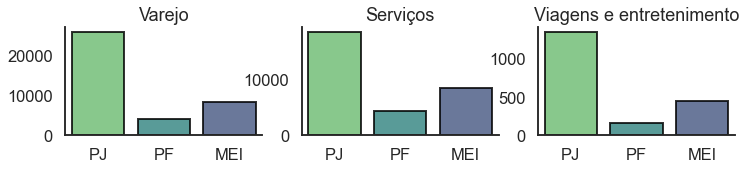

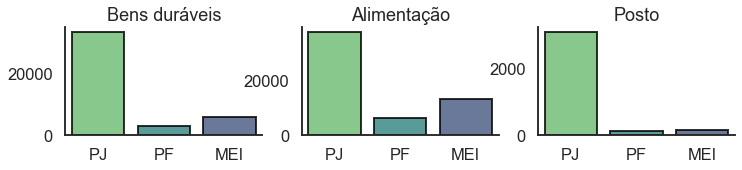

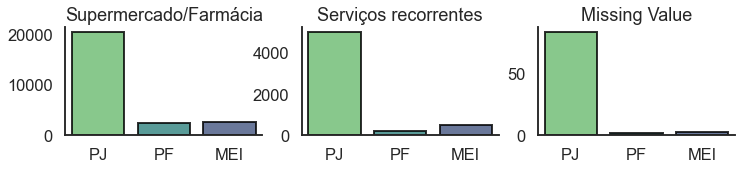

In [30]:
for ramo_1, ramo_2, ramo_3 in zip(cad_est_tpv_medio_ci['MacroClassificacao'].unique()[:3],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[3:6],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[6:9]):
    
    fig, axs = plt.subplots(1, 3, figsize = (12,2))
    order = ['PJ', 'PF', 'MEI']
    
    for ramo, ax in zip([ramo_1, ramo_2, ramo_3], [axs[0], axs[1], axs[2]]):
         
        data = cad_est_tpv_medio_ci[cad_est_tpv_medio_ci['MacroClassificacao'] == ramo]
        
        sns.countplot(x = 'tipo_documento', data = data,
                      order = order, ax = ax, **cp_kwargs)        

        ax.set(title = f"{ramo}",
               ylabel = '',
               xlabel = '');

MEI é considerado PJ e possui CNPJ próprio, o que me confundiu um pouco nessa separação. Imagino que com o PJ, o dataset se refira a Sociedades, EIRELIs e etc. e vou tirar conclusões a partir dessa suposição. 
<br>

É interessante perceber que a Stone **a maioria dos parceiros cadastrados como PJ, considerando que a maior parte das empresas brasileiras é MEI**. Ainda assim, no Brasil houve um aumento bem expressivo no número de sociedades, devido a criação das unipessoais, no ano de 2020 - 39,5% em relação à 2019. No entanto, a maior parte desse aumento se deu no final do ano de 2020, que não é contemplado nesse dataset.
<br>

Como esperado devido às restrições de receita de MEI e de PF, o **TPV-Mensal dos clientes PJ posssui mediana maior que o terceiro quartil dos outros dois**. Apesar disso, a distribuição do TPV nos 3 tipos é similar. 
<br>

Vamos analisar o crescimento do número de contas criadas pelo tipo de documento. Como o número de contas PJ é bem maior que os das outras contas, vou escalonar os dados para que o formato do crescimento de todos as contas fique evidente.

In [31]:
groupby_date_doc = cad_est_tpv_medio_ci[cad_est_tpv_medio_ci['StoneCreatedDate'] != cadastrais['StoneCreatedDate'].min()]\
                                                                .groupby(['tipo_documento', 'StoneCreatedDate']).count()

MEI_groupby_date_doc = groupby_date_doc.loc['MEI']
PF_groupby_date_doc = groupby_date_doc.loc['PF']
PJ_groupby_date_doc = groupby_date_doc.loc['PJ']

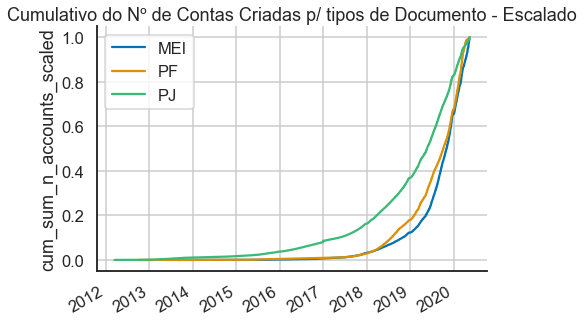

In [32]:
fig, ax = plt.subplots(figsize = (7,5))

for df, color, label in zip([MEI_groupby_date_doc, PF_groupby_date_doc, PJ_groupby_date_doc],
                            [pal[0], pal[1], g], ['MEI', 'PF', 'PJ']):
    
    df['cum_sum_n_accounts'] = df['id'].cumsum()
    
    scaler = MinMaxScaler()
    scaler.fit(np.array(df['cum_sum_n_accounts']).reshape(-1, 1))
    
    df['cum_sum_n_accounts_scaled'] = scaler.transform(np.array(df['cum_sum_n_accounts']).reshape(-1, 1))
    
    sns.lineplot(x = df.index, y = 'cum_sum_n_accounts_scaled',
                 data = df, color = color, ax = ax,
                 label = label)
    
ax.set(title = "Cumulativo do Nº de Contas Criadas p/ tipos de Documento - Escalado",
       xlabel = '');

fig.autofmt_xdate()
plt.grid()

**Apesar do crescimento de MEIs e PFs ter começado mais tarde (a partir da metade de 2017), eles estão crescendo em uma inclinação maior que o PJ** - o que pode indicar uma maior procura da Stone por esses parceiros, o crescimento do número de PFs e, principalmente, MEIs e o crescimento da procura por opções de meios de pagamento pelos últimos.  

### Estado

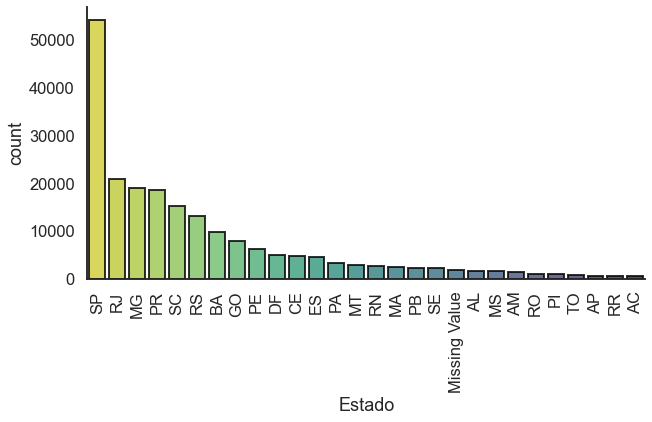

In [33]:
# Countplot para checar a participação da Stone em cada Estado

fig, ax = plt.subplots(figsize = (10,5))

order = np.array(cad_est_tpv_medio_ci['Estado'].value_counts().index)

sns.countplot(x = 'Estado', data = cad_est_tpv_medio_ci,
              ax = ax, order = order, **cp_kwargs);

plt.xticks(rotation = 90);

In [34]:
# Import na população BR por UF para relativizar - Dados: Estimativa IBGE 2020-2021

pop_uf = pd.read_excel('data/pop_brasileira_uf.xls')

dict_estados = {
                "São Paulo": "SP",
                "Minas Gerais": "MG",
                "Santa Catarina": "SC",
                "Paraná": "PR",
                "Rio de Janeiro":"RJ",
                "Goiás": "GO",
                "Pará": "PA",
                "Bahia": "BA",
                "Mato Grosso": "MT",
                "Rio Grande do Sul": "RS",
                "Maranhão": "MA",
                "Ceará": "CE",
                "Amazonas": "AM",
                "Distrito Federal": "DF",
                "Rondônia": "RO",
                "Espírito Santo": "ES",
                "Sergipe": "SE",
                "Roraima": "RR",
                "Tocantins": "TO",
                "Pernambuco": "PE",
                "Amapá": "AP",
                "Acre": "AC",
                "Paraíba": "PB",
                "Rio Grande do Norte": "RN",
                "Mato Grosso do Sul": "MS",
                "Alagoas": "AL",
                "Piauí": "PI",
                "Sao Paulo": "SP",
                "Parana": "PR",
}
pop_uf = pop_uf.replace(dict_estados)

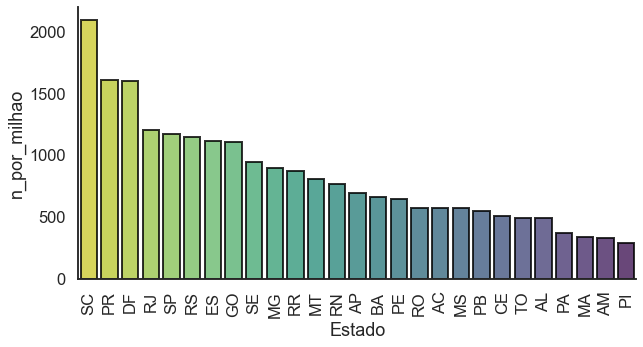

In [35]:
# Calculando o Número de Parceiros p/ milhão em cada Estado

groupby_estados = cad_est_tpv_medio_ci.groupby("Estado").count().drop("Missing Value")

groupby_estados['n_por_milhao'] = (groupby_estados['id'].values /\
                                  pop_uf.replace(dict_estados).set_index('UF').sort_index()['POP'].values) * 1000000

# Barplot para observar

fig, ax = plt.subplots(figsize = (10,5))

order = np.array(groupby_estados['n_por_milhao'].sort_values(ascending = False).index)

sns.barplot(x = groupby_estados.index, y = 'n_por_milhao',
            data = groupby_estados, ax = ax, order = order,
            **cp_kwargs);

plt.xticks(rotation = 90);

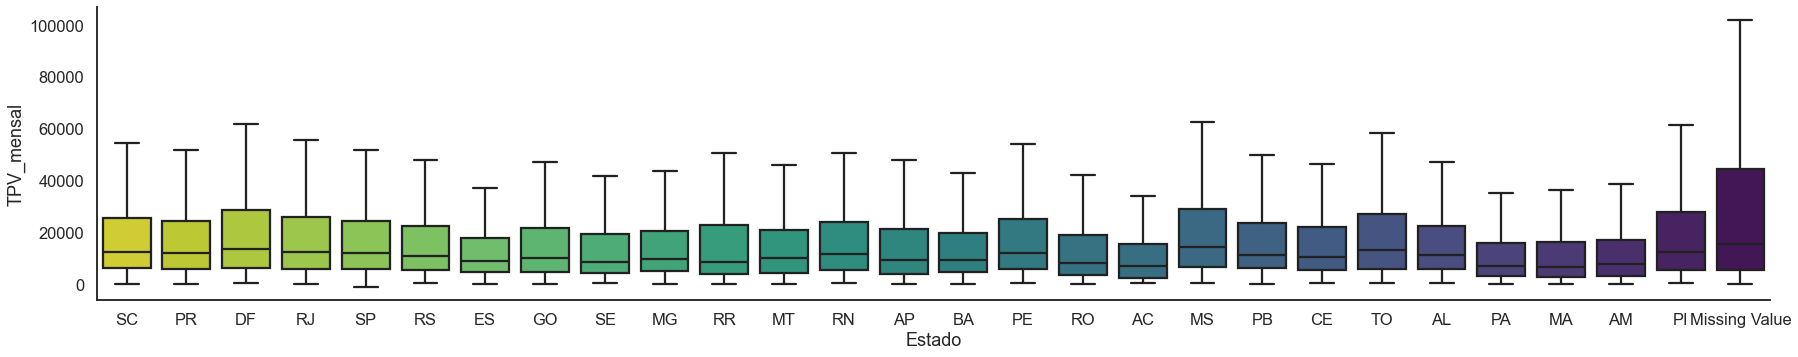

In [36]:
sns.catplot(x = 'Estado', y = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 5, order = np.append(order, "Missing Value"), 
            showfliers=False, palette = 'viridis_r');

Devido à população absoluta do estado de SP, é sempre esperado que ele seja o primeiro em valores absolutos - como foi o caso do número de contas. No entanto, em número de contas por milhão, os estados do sul PR e SC, seguidos pelo DF, estão no topo.

**A Stone tem grande presença no Sul, Sudeste e DF e menor participação nos estados do Nordeste e Norte.** 
<br>

Em relação ao desempenho do TPV-mensal por UF, **novamente os estados NaN tem comportamento completamente fora da curva**. Alguns **destaques positivos são o DF, MS, PE e o TO**, com a mediana acima dos outros estados. Já **o ES e a maior parte dos estados do Norte possuem a mediana abaixo**. 

### Persona

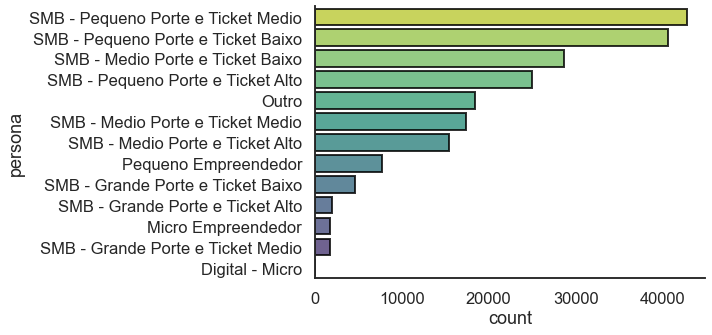

In [37]:
# Countplot para checar a participação da Stone em cada Estado

fig, ax = plt.subplots(figsize = (7,5))

order = np.array(cad_est_tpv_medio_ci['persona'].value_counts().index)

sns.countplot(y = 'persona', data = cad_est_tpv_medio_ci,
              ax = ax, order = order, **cp_kwargs);

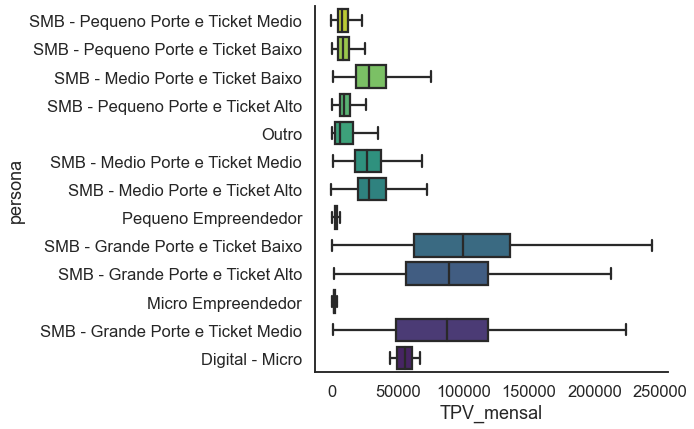

In [38]:
sns.catplot(y = 'persona', x = 'TPV_mensal',
            kind = 'box', data = cad_est_tpv_medio_ci,
            aspect = 1.6, height = 6, order = order, 
            showfliers=False, palette = 'viridis_r');

In [39]:
cad_est_tpv_medio_ci['persona'].value_counts()

SMB - Pequeno Porte e Ticket Medio    42708
SMB - Pequeno Porte e Ticket Baixo    40522
SMB - Medio Porte e Ticket Baixo      28639
SMB - Pequeno Porte e Ticket Alto     24924
Outro                                 18437
SMB - Medio Porte e Ticket Medio      17408
SMB - Medio Porte e Ticket Alto       15393
Pequeno Empreendedor                   7689
SMB - Grande Porte e Ticket Baixo      4599
SMB - Grande Porte e Ticket Alto       1959
Micro Empreendedor                     1800
SMB - Grande Porte e Ticket Medio      1753
Digital - Micro                           2
Name: persona, dtype: int64

Empresas de pequeno e médio porte, independente do tamanho do ticket, estão em maioria entre as parceiras da Stone. Vale a atenção ao "Digital - Micro" que deve ser incluído em outra categoria devido ao número de empresas. 
<br>

**Já na distribuição da média do TPV-Mensal, dá pra perceber que a diferença existe no tamanho do porte e não no tamanho do ticket**. Empresas de mesmo porte tem distribuição e estatísticas de localização parecida, enquanto diferenças no ticket não causam grandes diferenças. 

## TPV-Mensais

* Distribuição do TPV_mensal 

* Procurar relações entre o TPV-Mensal e as MacroClassificações
    * É possível visualizar o TPV-Mensal de diferentes empresas do mesmo ramo se comportando da mesma forma?

* É possível observar efeitos de time-series considerando o volume dos dados (poucos meses, MUITAS empresas)?
    * Sazonalidade, Estacionalidade e outros.
    


In [40]:
pd.set_option('display.max_columns', None)

# Merge no TPV-mensais c/ cad_est_tpv_medio_ci

tpv_cadastrais = tpv_mensais.merge(cad_est_tpv_medio_ci, on = 'id', suffixes = [None, '_medio'])

# Reorganização das colunas

tpv_cadastrais = tpv_cadastrais[['id', 'mes_referencia', 'TPV_mensal', 'MCC', 'MacroClassificacao',
                                'segmento', 'sub_segmento', 'persona', 'porte',
                                'tipo_documento', 'Estado', 'tem_duplicados', 'StoneCreatedDate',
                                'StoneFirstTransactionDate', 'diff_FirstTransaction_Created',
                                'TPVEstimate', 'TPV_mensal_medio', 'diff', 'TPV_medio_CI_LOW',
                                'TPV_medio_CI_HIGH', 'is_estimate_in_CI']]

tpv_cadastrais.head()

,id,mes_referencia,TPV_mensal,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate,diff_FirstTransaction_Created,TPVEstimate,TPV_mensal_medio,diff,TPV_medio_CI_LOW,TPV_medio_CI_HIGH,is_estimate_in_CI
0,1,2018-12-31,"10,107.90",5942,Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,PJ,MG,0,2018-12-12,2018-12-13,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
1,1,2019-01-31,"6,023.15",5942,Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,PJ,MG,0,2018-12-12,2018-12-13,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
2,1,2019-02-28,"4,347.30",5942,Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,PJ,MG,0,2018-12-12,2018-12-13,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
3,1,2019-03-31,"9,769.75",5942,Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,PJ,MG,0,2018-12-12,2018-12-13,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
4,1,2019-04-30,"6,701.70",5942,Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Medio Porte e Ticket Medio,50k-100k,PJ,MG,0,2018-12-12,2018-12-13,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0


C:\Users\bueni\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


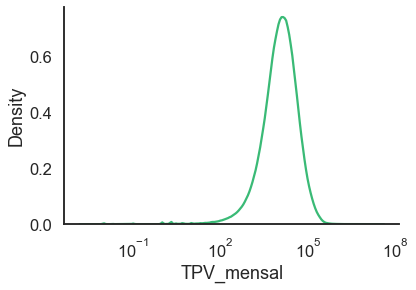

In [41]:
# Distribuição normal em escala log

sns.kdeplot(x = tpv_cadastrais[tpv_cadastrais['TPV_mensal'] != 0]['TPV_mensal'], log_scale = True, color = g)

### Sazonalidade

O alto volume de empresas e a baixa quantidade de dados temporais dificultam a análise através de separação de componentes utilizando alguma biblioteca como a StatsModels. 
<br>


Minha primeira tentativa será plotar o TPV-mensal escalonado(MinMaxScaler) através do tempo de muitas empresas da mesma MacroClassificação/Segmento e do mesmo porte em um gráfico, utilizando alta transparência na linha. 

**Em momentos que o TPV-mensal das empresas se comportarem de forma similar, a linha ficará mais escura** e será possível verificar (ou não) a presença de algum tipo de sazonalidade ou, pelo menos, confirmar características similares do TPV de acordo com o ramo. 

Vale lembrar que a maior parte das empresas tem suas transações com a Stone começando nos últimos 2 anos, o que ocasionará um escurecimento no final do eixo X. Devido à isso, utilizarei apenas os 12 meses de 2019.

#### MacroClassificacao

In [42]:
# Agrupar por Macro Classificação e Porte -> Identificar comportamento
grouped_tpv_cad = tpv_cadastrais.groupby(['MacroClassificacao','porte', 'id', 'mes_referencia']).sum()

grouped_tpv_cad

TPV_mensal  \
MacroClassificacao       porte  id     mes_referencia               
Alimentação              0-2.5k 41     2020-04-30          242.21   
                                       2020-05-31          685.66   
                                       2020-06-30          939.71   
                                       2020-07-31        3,900.98   
                                72     2019-12-31          905.80   
...                                                           ...   
Viagens e entretenimento 5k-10k 206311 2020-03-31       11,369.95   
                                       2020-04-30        5,953.60   
                                       2020-05-31        3,687.25   
                                       2020-06-30        2,803.40   
                                       2020-07-31        4,611.10   

                                                       diff_FirstTransaction_Created  \
MacroClassificacao       porte  id     mes_referencia                                  
Alimentação              0-2.5k 41     2020-04-30                                  3   
                                       2020-05-31                                  3   
                                       2020-06-30                                  3   
                                       2020-07-31                                  3   
                                72     2019-12-31                                  3   
...                                                                              ...   
Viagens e entretenimento 5k-10k 206311 2020-03-31                                  5   
                                       2020-04-30                                  5   
                                       2020-05-31                                  5   
                                       2020-06-30                                  5   
                                       2020-07-31                                  5   

                                                       TPVEstimate  \
MacroClassificacao       porte  id     mes_referencia                
Alimentação              0-2.5k 41     2020-04-30         1,000.00   
                                       2020-05-31         1,000.00   
                                       2020-06-30         1,000.00   
                                       2020-07-31         1,000.00   
                                72     2019-12-31             0.00   
...                                                            ...   
Viagens e entretenimento 5k-10k 206311 2020-03-31         8,000.00   
                                       2020-04-30         8,000.00   
                                       2020-05-31         8,000.00   
                                       2020-06-30         8,000.00   
                                       2020-07-31         8,000.00   

                                                       TPV_mensal_medio  \
MacroClassificacao       porte  id     mes_referencia                     
Alimentação              0-2.5k 41     2020-04-30              1,442.14   
                                       2020-05-31              1,442.14   
                                       2020-06-30              1,442.14   
                                       2020-07-31              1,442.14   
                                72     2019-12-31                877.06   
...                                                                 ...   
Viagens e entretenimento 5k-10k 206311 2020-03-31              5,203.69   
                                       2020-04-30              5,203.69   
                                       2020-05-31              5,203.69   
                                       2020-06-30              5,203.69   
                                       2020-07-31              5,203.69   

                                                          diff  \
MacroClassificacao       porte  id     mes_referencia      

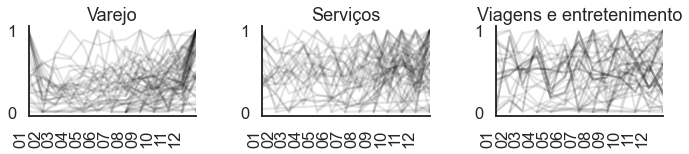

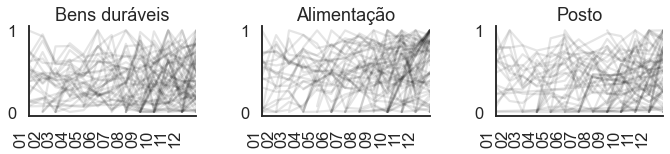

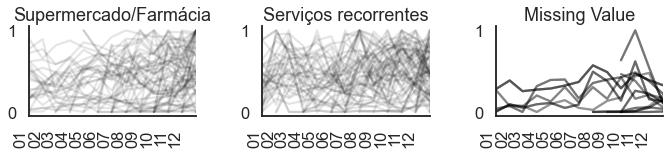

In [43]:
np.random.seed(42)
datemin = np.datetime64('2019-01-01')
datemax = np.datetime64('2019-12-31')
 
for ramo_1, ramo_2, ramo_3 in zip(cad_est_tpv_medio_ci['MacroClassificacao'].unique()[:3],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[3:6],
                                  cad_est_tpv_medio_ci['MacroClassificacao'].unique()[6:9]):
        
    fig, axs = plt.subplots(1, 3, figsize = (10,2))
    plt.tight_layout()

    for ax, ramo in zip(axs, [ramo_1, ramo_2, ramo_3]):
            
        random_ids = np.random.choice(np.array(cadastrais[(cadastrais.MacroClassificacao == ramo) & \
                                                      (cadastrais.porte == '10k-25k')]['id'].unique()),
                                      size = 100) # Seleciona apenas 100 ids para o plot
            
        for random_id in random_ids:

            df = grouped_tpv_cad.loc[ramo].loc['10k-25k'].loc[random_id]

            scaler = MinMaxScaler() # Escala para que eliminar o scale e facilitar a análise de trend
            scaler.fit(np.array(df['TPV_mensal']).reshape(-1, 1))

            tpv_scaled = scaler.transform(np.array(df['TPV_mensal']).reshape(-1, 1)).T[0]

            sns.lineplot(x = df.index, y = tpv_scaled,
                             ax = ax, color = 'k', alpha = 0.1)
    
            ax.set(title = f'{ramo}',
                   xlabel = '',
                   xlim = (datemin, datemax))

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
            fig.autofmt_xdate(rotation=90)

#### Segmento

In [44]:
# Agrupar por Segmento e Porte -> Identificar comportamento geral de cada segmento

grouped_tpv_cad_seg = tpv_cadastrais.groupby(['segmento','porte', 'id', 'mes_referencia']).sum()

grouped_tpv_cad_seg

TPV_mensal  \
segmento              porte  id     mes_referencia               
Alimentação e Bebidas 0-2.5k 41     2020-04-30          242.21   
                                    2020-05-31          685.66   
                                    2020-06-30          939.71   
                                    2020-07-31        3,900.98   
                             72     2019-12-31          905.80   
...                                                        ...   
Telecomunicações      5k-10k 206077 2020-03-31        1,275.00   
                                    2020-04-30        3,930.00   
                                    2020-05-31        2,770.00   
                                    2020-06-30        2,635.00   
                                    2020-07-31        4,264.00   

                                                    diff_FirstTransaction_Created  \
segmento              porte  id     mes_referencia                                  
Alimentação e Bebidas 0-2.5k 41     2020-04-30                                  3   
                                    2020-05-31                                  3   
                                    2020-06-30                                  3   
                                    2020-07-31                                  3   
                             72     2019-12-31                                  3   
...                                                                           ...   
Telecomunicações      5k-10k 206077 2020-03-31                                  1   
                                    2020-04-30                                  1   
                                    2020-05-31                                  1   
                                    2020-06-30                                  1   
                                    2020-07-31                                  1   

                                                    TPVEstimate  \
segmento              porte  id     mes_referencia                
Alimentação e Bebidas 0-2.5k 41     2020-04-30         1,000.00   
                                    2020-05-31         1,000.00   
                                    2020-06-30         1,000.00   
                                    2020-07-31         1,000.00   
                             72     2019-12-31             0.00   
...                                                         ...   
Telecomunicações      5k-10k 206077 2020-03-31        10,000.00   
                                    2020-04-30        10,000.00   
                                    2020-05-31        10,000.00   
                                    2020-06-30        10,000.00   
                                    2020-07-31        10,000.00   

                                                    TPV_mensal_medio     diff  \
segmento              porte  id     mes_referencia                              
Alimentação e Bebidas 0-2.5k 41     2020-04-30              1,442.14  -442.14   
                                    2020-05-31              1,442.14  -442.14   
                                    2020-06-30              1,442.14  -442.14   
                                    2020-07-31              1,442.14  -442.14   
                             72     2019-12-31                877.06  -877.06   
...                                                              ...      ...   
Telecomunicações      5k-10k 206077 2020-03-31              4,497.71 5,502.29   
                                    2020-04-30              4,497.71 5,502.29   
                                    2020-05-31              4,497.71 5,502.29   
                                    2020-06-30              4,497.71 5,502.29   
                                    2020-07-31              4,497.71 5,502.29   

                                                    TPV_medio_CI_LOW  \
segmento              porte  id     mes_referencia                     
Alimentação e Beb

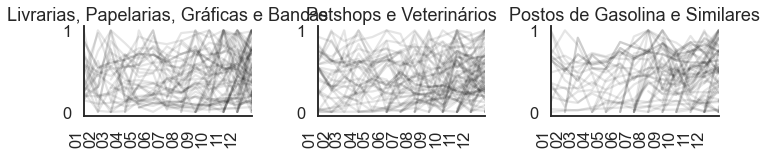

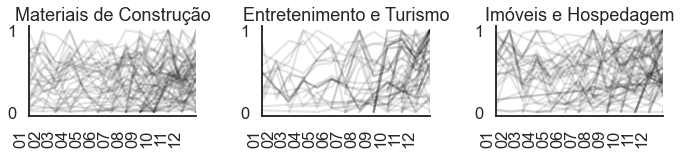

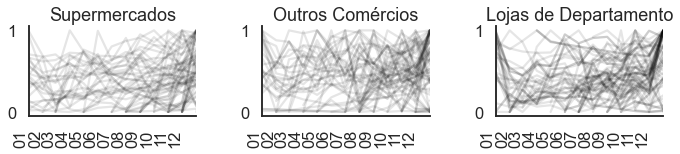

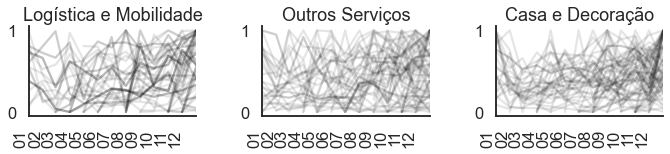

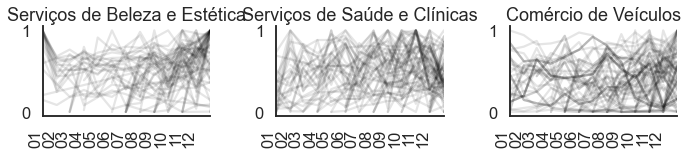

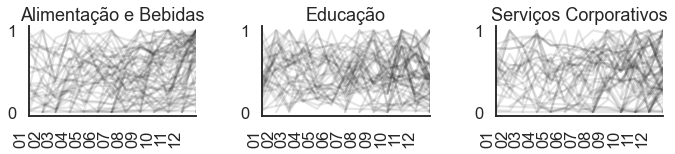

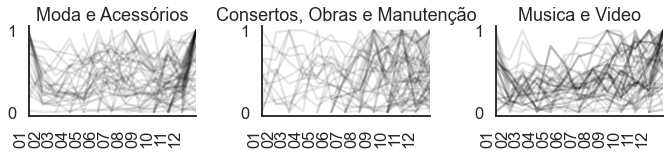

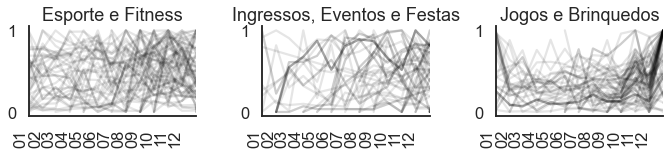

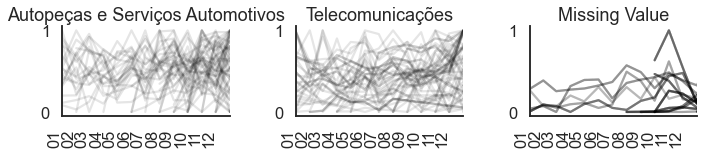

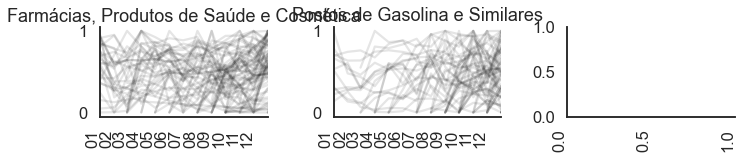

In [45]:
np.random.seed(42)
 
for ramo_1, ramo_2, ramo_3 in zip(cad_est_tpv_medio_ci['segmento'].unique()[:10],
                                  cad_est_tpv_medio_ci['segmento'].unique()[11:21],
                                  cad_est_tpv_medio_ci['segmento'].unique()[20:30]):
    
    fig, axs = plt.subplots(1, 3, figsize = (10,2))
    plt.tight_layout()

        
    for ax, ramo in zip(axs, [ramo_1, ramo_2, ramo_3]):
            
        try:
            random_ids = np.random.choice(np.array(cadastrais[(cadastrais.segmento == ramo) & \
                                                              (cadastrais.porte == '10k-25k')]['id'].unique()),
                                          size = 100)

            for random_id in random_ids:

                df = grouped_tpv_cad_seg.loc[ramo].loc['10k-25k'].loc[random_id]

                scaler = MinMaxScaler()
                scaler.fit(np.array(df['TPV_mensal']).reshape(-1, 1))

                tpv_scaled = scaler.transform(np.array(df['TPV_mensal']).reshape(-1, 1)).T[0]

                sns.lineplot(x = df.index, y = tpv_scaled,
                                 ax = ax, color = 'k', alpha = 0.1)

                ax.set(title = f'{ramo}',
                       xlabel = '',
                       xlim = (datemin, datemax))
                
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

                fig.autofmt_xdate(rotation=90)
                
        except ValueError:
            pass

Até é possível ver algumas trends utilizando esse método, mas ele cria muito noise e a análise é bem difícil. Ainda assim, no Varejo e seus segmentos dá pra verificar um aumento próximo ao final do ano.  

Acredito que aumentar o número de samples e reduzir a opacidade melhoraria os resultados. No entanto, isso aumenta bastante o tempo para a célula rodar.

### StatsModels - Análise de Decomposição de Séries Temporais

Para realizar a análise de decomposição, separei a mediana do TPV-Mensal de todo o dataset e também por segmento.

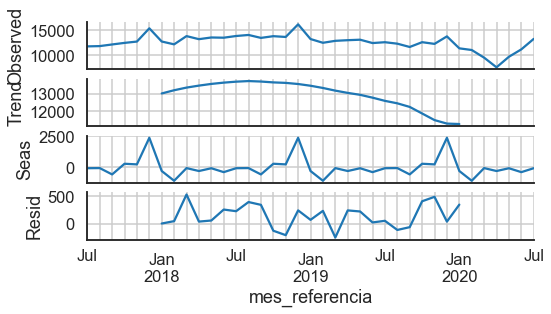

In [46]:
# Análise do Dataset todo -> Seleciono median devido ao volume de outliers

time_series = tpv_cadastrais.groupby('mes_referencia').median().loc[:, 'TPV_mensal']

result = seasonal_decompose(time_series, model ='additive', period = 12)

fig, axs = plt.subplots(4, 1, figsize = (8,4), sharex = True)

result.observed.plot(ax=axs[0], ylabel = 'Observed')
result.trend.plot(ax=axs[1], ylabel = 'Trend')
result.seasonal.plot(ax=axs[2], ylabel = 'Seas')
result.resid.plot(ax=axs[3], ylabel = 'Resid')

for ax in axs:
    ax.grid(which = 'both')

É possível verificar que a mediana do TPV-mensal vem caindo desde janeiro de 2018. Além disso, dá pra ver também o aumento expressivo durante o final do ano, já começando em Outubro. Ainda na sazonalidade, dá pra ver também a recessão causada em Janeiro pelos gastos do feitos no final do ano. 

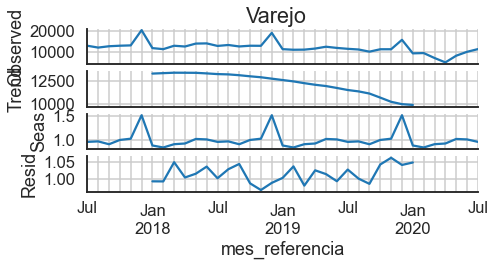

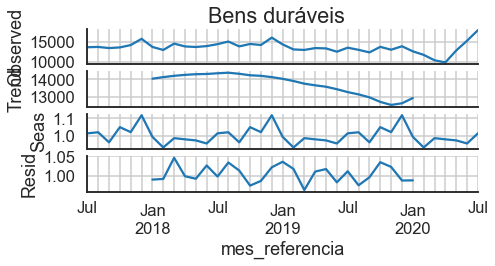

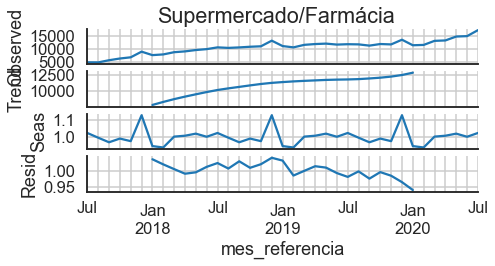

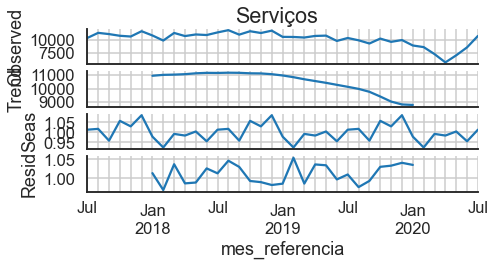

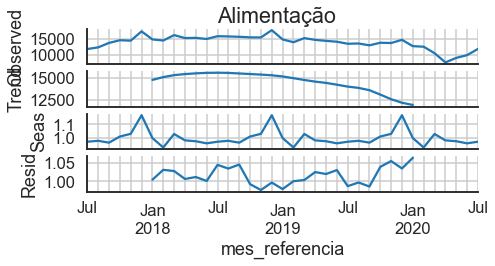

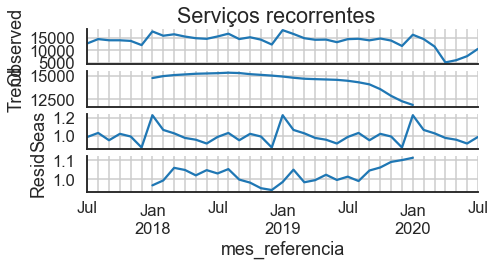

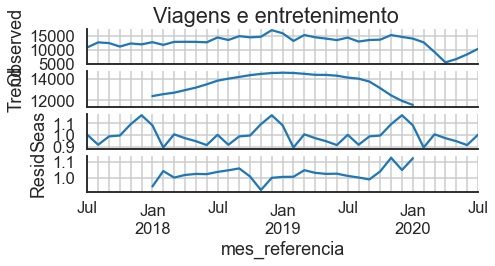

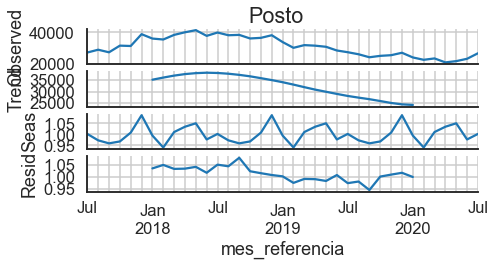

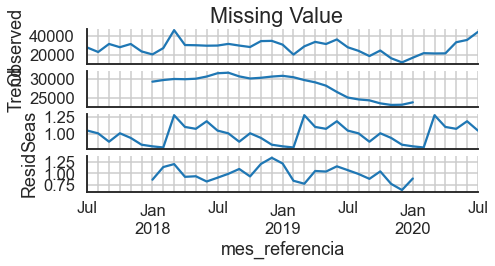

In [47]:
# Análise por MacroClassificação -> Seleciono median devido ao volume de outliers

data = tpv_cadastrais.groupby(["MacroClassificacao", 'mes_referencia']).median()

for ramo in np.array(cadastrais['MacroClassificacao'].unique()):

    time_series = data.loc[ramo, 'TPV_mensal']
    
    result = seasonal_decompose(time_series, model ='multiplicative', period = 12)

    fig, axs = plt.subplots(4, figsize = (7, 3), sharex = True)

    result.observed.plot(ax=axs[0], ylabel = 'Observed')
    result.trend.plot(ax=axs[1], ylabel = 'Trend')
    result.seasonal.plot(ax=axs[2], ylabel = 'Seas')
    result.resid.plot(ax=axs[3], ylabel = 'Resid')
    
    fig.suptitle(ramo)
    for ax in axs:
        ax.grid(which = 'both')
        
    plt.show()

* **Tendência**

    * Assim como no dataset inteiro, as MacroClassificações Posto, Missing Value, Serviços, Serviços Recorrentes, Alimentação, Bens Duráveis e Varejo estão com a mediana do TPV-Mensal em queda. Viagens e Entretenimento coomeçou 2018 subindo mas voltou a cair após atingir um platô em 2019. Pelo contrário, a mediana do TPV-Mensal super mercados e farmácias está subindo.

    * Vale lembrar que houve um aumento exponencial no número de MEIs e PFs a partir do meio de 2017, o que pode explicar a tendência de queda da mediana do TPV-Mensal em muitas macroclassificações, uma vez que empresas menores estão entrando.


* **Sazonalidade**

    * Como esperado, os meses de Novembro e Dezembro são favoráveis pra grande maioria das empresas. É possível notar um aumento nos valores desses meses em quase todas as macroclassificações.

    * Apesar de algumas similaridades, dá pra notar também que o comportamento da sazonalidade, mesmo considerando apenas a mediana, é diferente entre as classificações.

### TPV-Mensal por segmento

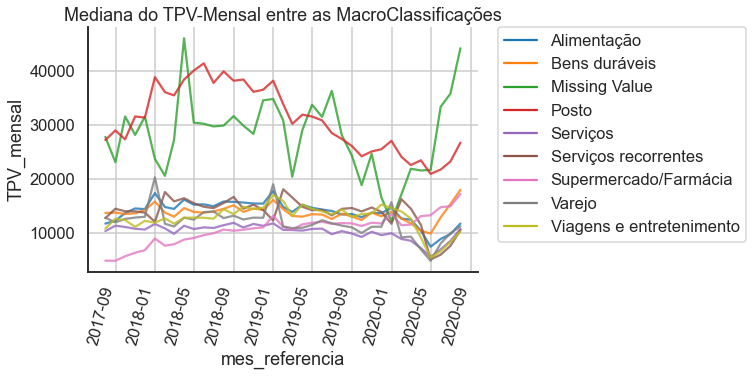

In [48]:
fig, ax = plt.subplots(figsize = (7,5))

sns.lineplot(y = data['TPV_mensal'], x = data.index.get_level_values('mes_referencia'),
            hue = data.index.get_level_values('MacroClassificacao'),
            alpha = 0.8).set_title("Mediana do TPV-Mensal entre as MacroClassificações")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.autofmt_xdate(rotation=75)
plt.grid()

### TPV-Mensal Cumulativo por segmento

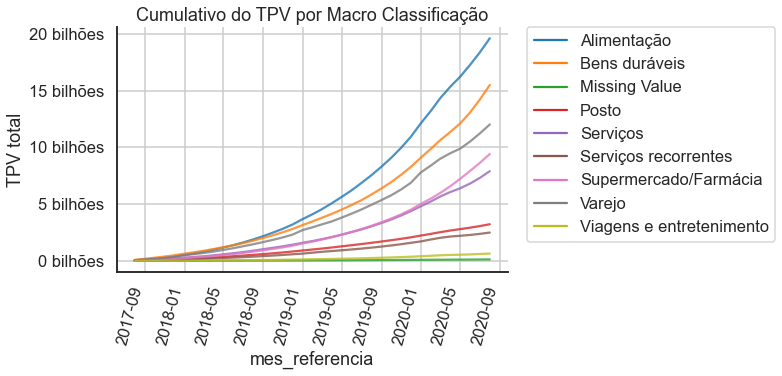

In [49]:
fig, ax = plt.subplots(figsize = (7,5))

data = tpv_cadastrais.groupby(["MacroClassificacao", 'mes_referencia']).sum()

data['cumsum'] = data.groupby(level=0)['TPV_mensal'].cumsum()


ax = sns.lineplot(y = data['cumsum'], x = data.index.get_level_values('mes_referencia'),
                 hue = data.index.get_level_values('MacroClassificacao'),
                 alpha = 0.8)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000000) + ' bilhões'))

ax.set(title = "Cumulativo do TPV por Macro Classificação",
       ylabel = 'TPV total')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.autofmt_xdate(rotation=75)
plt.grid()

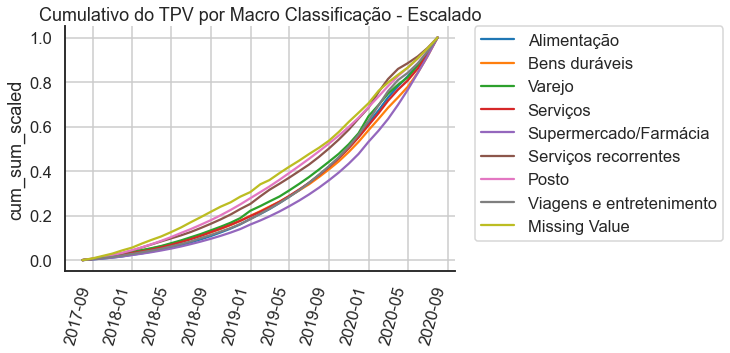

In [50]:
pd.options.mode.chained_assignment = None

fig, ax = plt.subplots(figsize = (7,5))

for ramo, color in zip(np.array(cadastrais['MacroClassificacao'].value_counts().index), sns.color_palette('tab10')):
    
    df = data.loc[ramo]
    
    scaler = MinMaxScaler()
    scaler.fit(np.array(df.loc[:, 'cumsum']).reshape(-1, 1))
    
    df.loc[:, 'cum_sum_scaled'] = scaler.transform(np.array(df.loc[:, 'cumsum']).reshape(-1, 1))
    
    sns.lineplot(x = df.index, y = 'cum_sum_scaled',
                 data = df, color = color, ax = ax,
                 label = ramo)

ax.set(title = "Cumulativo do TPV por Macro Classificação - Escalado",
       xlabel = '')
                       
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.autofmt_xdate(rotation=75)
plt.grid()